In [1]:
# import torch
import numpy as np
import data_pipes

df_path = "processed_aapl_data.csv"
data = data_pipes.process_df_3(df_path)
x, y, close = data["x"], data["y"], data["close"]
# y = (y - y.min()) / (y.max() - y.min())
# y = y - y.mean()
print(f"""
x shape: {x.shape}
y shape: {y.shape}     
close shape: {close.shape} 
""")


x shape: (2427, 20, 13)
y shape: (2427, 1)     
close shape: (2427, 1) 



In [2]:
from torch import nn

class L1LossWithStdReward(nn.Module):
    def __init__(self, reward_weight=1.0, reduction='mean'):
        """
        Initializes the custom loss.

        Args:
            reward_weight (float): Hyperparameter controlling the weight of the standard deviation reward.
            reduction (str): Specifies the reduction to apply to the L1 loss ('mean' or 'sum').
        """
        super(L1LossWithStdReward, self).__init__()
        self.l1_loss = nn.L1Loss(reduction=reduction)
        self.reward_weight = reward_weight
        
    def forward(self, outputs, targets):
        # Compute the standard L1 loss between outputs and targets.
        loss = self.l1_loss(outputs, targets)
        
        # Calculate the standard deviation of the outputs.
        # This computes the std over all elements in the output tensor.
        std_reward = torch.std(outputs)
        
        # Subtract the reward term (i.e. reward for high std) from the L1 loss.
        total_loss = loss - self.reward_weight * std_reward
        return total_loss
        
class georgia_1(nn.Module):
    def __init__(self, config, win_past=20, features=13, bias=False):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())

        for idx in range(len(config['neurons'])):
            if config['activations'][idx] == 'relu':
                activation = nn.ReLU()
            elif config['activations'][idx] == 'selu':
                activation = nn.SELU()
            elif config['activations'][idx] == 'sigmoid':
                activation = nn.Sigmoid()
            elif config['activations'][idx] == 'tanh':
                activation = nn.Tanh()
            elif config['activations'][idx] == 'none':
                activation = "none"
            else:
                raise ValueError(f"Unrecognized activation function at index {idx}: {config['activations'][idx]}")

            if idx == 0:
                self.layers.append(nn.Linear(features*win_past, config['neurons'][idx], bias=bias))
            else:
                self.layers.append(nn.Linear(config['neurons'][idx - 1], config['neurons'][idx], bias=bias))

            if activation != 'none':
                self.layers.append(activation)

            self.layers.append(nn.Dropout(config['dropouts'][idx]))
        
        # self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                
                nn.init.trunc_normal_(m.weight, mean=0, std=1)  # Set mean=0, std=1
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Optional: Initialize biases to 0

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

v_split = 0.5
v_cutoff = int(len(x)*(1 - v_split))
x_t = torch.tensor(x[:v_cutoff], dtype=torch.float32).to(device)
x_v = torch.tensor(x[v_cutoff:], dtype=torch.float32).to(device)
y_t = torch.tensor(y[:v_cutoff], dtype=torch.float32).to(device)
y_v = torch.tensor(y[v_cutoff:], dtype=torch.float32).to(device)
close_t = close[:v_cutoff]
close_v = close[v_cutoff:]

In [4]:
import time
from torch import optim
import torch_ops as ops

def train_model(
    model,
    data,
    v_split,
    optimizer,
    loss_fn,
    batch_size=32,
    epochs=250,
    verbose=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x, y, close = data["x"], data["y"], data["close"]
    v_cutoff = int(len(x)*(1 - v_split))
    x_t = torch.tensor(x[:v_cutoff], dtype=torch.float32).to(device)
    y_t = torch.tensor(y[:v_cutoff], dtype=torch.float32).to(device)
    close_t = torch.tensor(close[:v_cutoff], dtype=torch.float32).to(device)
    x_v = torch.tensor(x[v_cutoff:], dtype=torch.float32).to(device)
    y_v = torch.tensor(y[v_cutoff:], dtype=torch.float32).to(device)
    close_v = torch.tensor(close[v_cutoff:], dtype=torch.float32).to(device)
    
    used_data = {
        "x_t": x_t,
        "y_t": y_t,
        "close_t": close_t,
        "x_v": x_v,
        "y_v": y_v,
        "close_v": close_v,
    }

    loss = ops.test_loop(x_t, y_t, model, loss_fn, batch_size)
    test_loss = ops.test_loop(x_v, y_v, model, loss_fn, batch_size)
    best_test_loss = test_loss
    if verbose:
        print("---------- Epoch 0 ----------")
        print(f"loss: {loss:1.4f}, test loss: {test_loss:1.4f}")

    t0 = time.perf_counter()
    for epoch in range(epochs):
        loss = ops.train_loop(x_t, y_t, model, loss_fn, optimizer, batch_size)
        # print(f"epoch: {epoch}, loss: {loss:1.4f}")
        test_loss_new = ops.test_loop(x_v, y_v, model, loss_fn, batch_size)
        best_test_loss = min(best_test_loss, test_loss_new)

        if verbose:
            if test_loss_new < test_loss or epoch == epochs - 1:
                print(f"---------- Epoch {epoch + 1} ----------")
                print(f"loss: {loss:1.4f}, test loss: {test_loss_new:1.4f}")
            
            # improvement = test_loss_new < test_loss
            # if improvement:
            #     test_loss = test_loss_new
            #     print(f"Checkpoint: test loss = {test_loss:1.4f} <---------------")
            #     torch.save(model.state_dict(), r"models/hanzo_0")

    t1 = time.perf_counter()
    print(f"Training done in {t1 - t0:5.2f} s.")

    return {"loss": loss, "test_loss": test_loss, "used_data": used_data}

In [5]:
win_past, features = x.shape[1], x.shape[2]
verbose = True
# model_config = random_model_config()
model_config = {
    'neurons': [128, 256, 256, 128, 32, 1],
    'activations': ['none', 'selu', 'selu', 'selu', 'selu', 'tanh'],
    'dropouts': [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
}

model = georgia_1(
    model_config,
    win_past=win_past,
    features=features,
    bias=False
    ).to(device)

model1 = georgia_1(
    model_config,
    win_past=win_past,
    features=features,
    bias=False
    ).to(device)

lr = 1e-7
l2_decay = 0
optimizer = optim.NAdam(
    params=model.parameters(),
    lr=lr,
    # weight_decay=l2_decay
    )

# loss_fn = L1LossWithStdReward(reward_weight=0.3)
loss_fn = nn.L1Loss()

epochs = 500
batch_size = 32
results = train_model(
    model,
    data,
    v_split=0.5,
    optimizer=optimizer,
    loss_fn=loss_fn,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False
)
results1 = train_model(
    model1,
    data,
    v_split=0.5,
    optimizer=optimizer,
    loss_fn=loss_fn,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False
)

Training done in  3.84 s.
Training done in  3.19 s.


In [ ]:
from torch_ops import train_loop

win_train = 20
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

for t in range(win_train, len(x)):
# t = win_train

    model = georgia_1(
        model_config,
        win_past=win_past,
        features=features,
        bias=False
        ).to(device)
    x_slice = x_tensor[t - win_train: t]
    y_slice = y_tensor[t - win_train: t]
    tmp_results = train_loop(x_slice, y_slice, model)
    y_train = model(x_train)

In [16]:
time

<module 'time' (built-in)>

<Figure size 640x480 with 0 Axes>

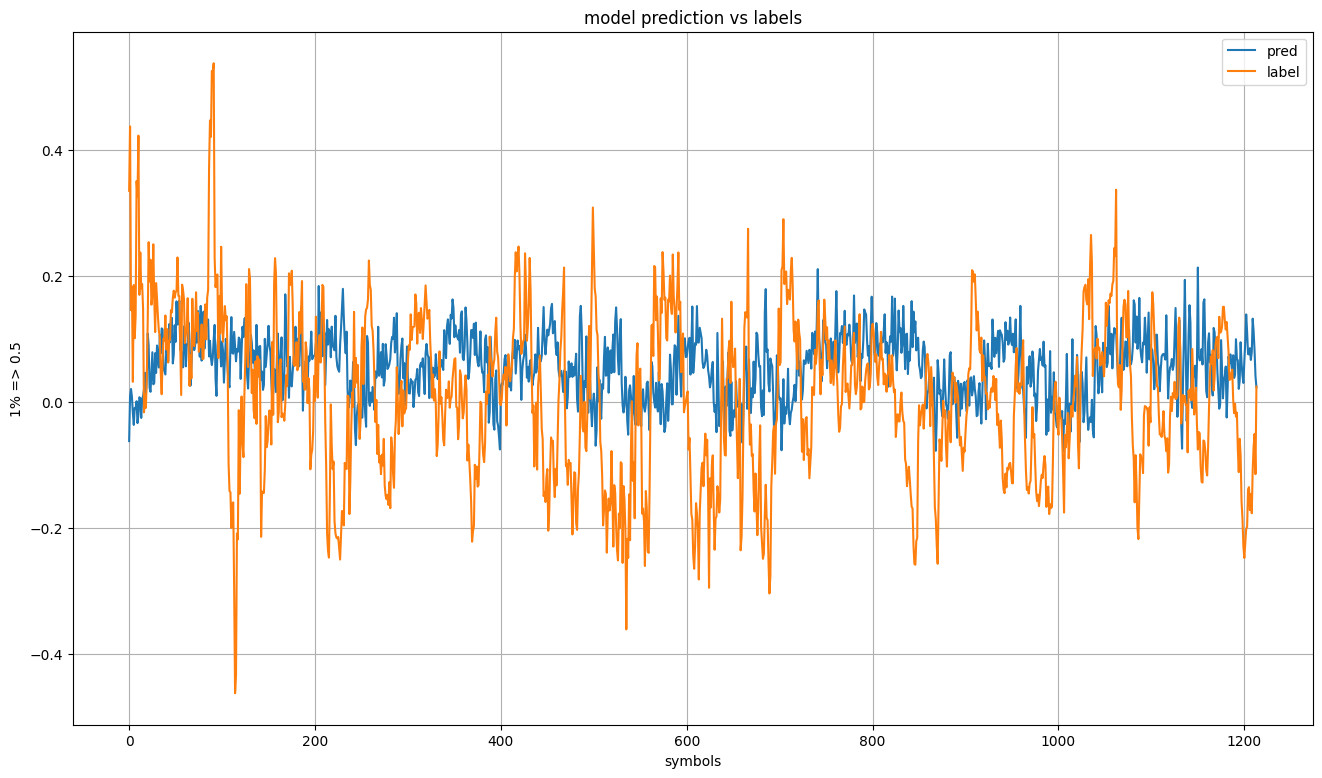

In [67]:
from matplotlib import pyplot as plt

# pred = model(x_v).to('cpu').detach().numpy()
# label = y_v.to('cpu').detach().numpy()

pred = model1(x_v).to('cpu').detach().numpy()
label = y_v.to('cpu').detach().numpy()
sym_index = np.arange(pred.shape[1])

fig = plt.figure()
plt.figure(figsize=(16, 9))
plt.title("model prediction vs labels")
plt.xlabel("symbols")
plt.ylabel("1% => 0.5")

plt.plot(pred, label="pred")
plt.plot(label, label="label")

plt.grid()
plt.legend()
plt.show()